# Belief

Belief is a central concept in stochastic estimation and control.  In many real world problems, the exact state of the system $x \in \mathbb{R}^n$ is unknown, and thus considered a random variable.  We represent belief in state as a probability distribution $p(x)$.  With this statistical representation, we can reason about the most likely state (expectation) as well as a level of trust in it (confidence/uncertainty).  Many software packages provide statistical representations, but because belief is central to stochastic estimation, several common/useful builtins are included with `sia`, with the ability to integrate with other libraries (by subclassing `sia.Distribution`).  This example shows basic usage of the distributions.

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(10)

## 1D Parametric Distributions
These distributions $p(x|\theta)$ represent a random variable $x \in \mathbb{R}$ with a parameter set $\theta$.  Two common distributions are Gaussian $\mathcal{N}(x|\mu,\sigma^2)$ and Uniform $\mathcal{U}(x|a,b)$.
- `sia.Gaussian`.  Gaussians are the statistical equivalent of linear systems, i.e. the probabilities obey superposition.  They are fully represented by statistical parameters $\theta = \{\mu, \sigma^2\}$.  Due to linearity, they are often used in conjunction with linear systems.
- `sia.Uniform`.  Uniform distributions are useful as a prior belief for non-linear filters when we are completely uncertain about the initial state but have some idea of reasonable lower and upper bounds $\theta = \{a, b\}$.  In this case, all samples in the distribution are equally probable.  Another way to say this is the uniform distribution has the highest Shannon entropy out of possible distributions.

In this example we show a couple 1D parameterizations with their statistics, and sampling from them.

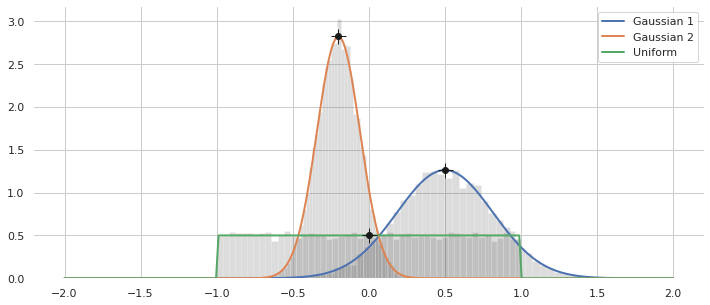

In [2]:
distributions = {
    "Gaussian 1": sia.Gaussian(mean=0.5, variance=0.1),
    "Gaussian 2": sia.Gaussian(mean=-0.2, variance=0.02),
    "Uniform": sia.Uniform(lower=-1.0, upper=1.0),
}
        
# Plot the probabilities
f, ax = plt.subplots(figsize=(12, 5))
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
x = np.linspace(-2, 2, 250)
for name, dist in distributions.items():
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb1d(dist, x))
    plt.plot(x, prob, label=name, lw=2)
    
    # Add dots for the distribution means
    mean = dist.mean()
    plt.plot(mean, np.exp(dist.logProb(mean)), ".k", ms=12)
    
    # Add plusses for the distribution modes
    mode = dist.mode()
    plt.plot(mode, np.exp(dist.logProb(mode)), "+k", ms=15)
    
    # Draw samples and plot a histogram
    s_sia = dist.samples(10000)
    plt.hist(np.array(s_sia), 50, density=True, color="k", edgecolor=None,  alpha=0.15)

plt.legend()
plt.show()

Sia also provides support for representing multiple categories using a Dirichlet distribution $x\sim\mathcal{D}(\alpha)$.
- `sia.Dirichlet`.  Dirichlet distributions represent a mutivariate continuous random variable $x_i\in(0, 1)$ where $\sum x_i = 1$, and are parameterized by a vector of concentrations $\theta =\{\alpha\}$ of the same dimension.  This is useful for representing the likelihood of multiple categories.  The 2D case (i.e. a binary class) is equivalent to the Beta distribution.  

An example of the Beta case is shown below.

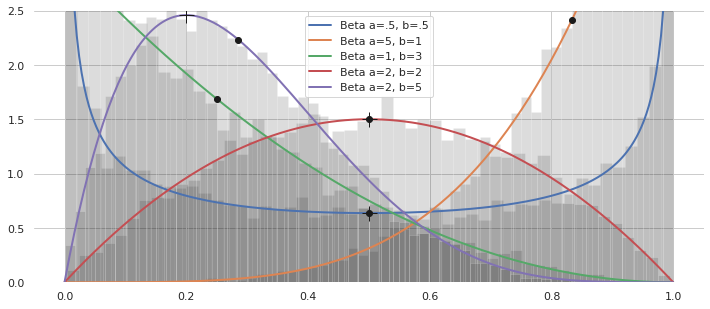

In [3]:
distributions = {
    "Beta a=.5, b=.5": sia.Dirichlet(alpha=.5, beta=.5),
    "Beta a=5, b=1": sia.Dirichlet(alpha=5, beta=1),
    "Beta a=1, b=3": sia.Dirichlet(alpha=1, beta=3),
    "Beta a=2, b=2": sia.Dirichlet(alpha=2, beta=2),
    "Beta a=2, b=5": sia.Dirichlet(alpha=2, beta=5),
}

# Plot the probabilities
f, ax = plt.subplots(figsize=(12, 5))
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
# Note that the Dirichlet distribution requires 1 dimension for each 
# category, so a binary classifier has dimension 2.  Here we only plot
# the 1st axis.  The 2nd axis is the reflection of the Beta random variable.
x = np.linspace(0, 1, 250)
axis = 0
for name, dist in distributions.items():
    pass
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb2d(dist, x, 1-x))
    plt.plot(x, prob, label=name, lw=2)
    
    # Add dots for the distribution means
    mean = dist.mean()
    plt.plot(mean[axis], np.exp(dist.logProb(mean)), ".k", ms=12)
    
    # Add plusses for the distribution modes
    mode = dist.mode()
    plt.plot(mode[axis], np.exp(dist.logProb(mode)), "+k", ms=15)
    
    # Draw samples and plot a histogram
    s_sia = dist.samples(10000)
    plt.hist(np.array(s_sia)[:, axis], 50, density=True, color="k", edgecolor=None,  alpha=0.15)

plt.ylim((0, 2.5))
plt.legend()
plt.show()

## n-D Parametric Distributions
Distributions in `sia` are defined over an $n$-dimensional state.  In this case we show examples of probabilities for 2D Gaussian distributions $\mathcal{N}(x|\mu,\Sigma)$, where $\mu$ is the mean and $\Sigma$ is the covariance.

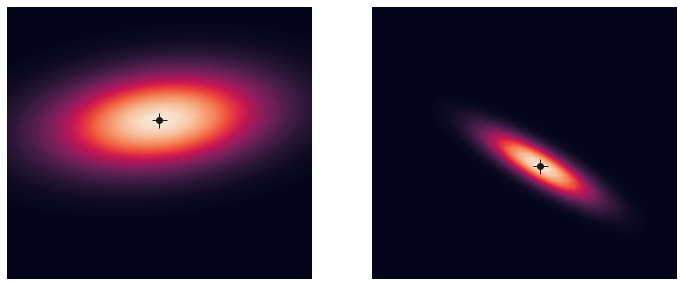

In [4]:
distributions = {
    "Gaussian 1": sia.Gaussian(mean=np.array([0, 0.5]),
                               covariance=np.array([[2, 0.2], [0.2, 0.5]])),
    "Gaussian 2": sia.Gaussian(mean=np.array([0.3, -0.5]),
                               covariance=np.array([[0.5, -0.3], [-0.3, 0.25]])),
}

# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
x = np.linspace(-3, 3, 51)
y = np.linspace(-3, 3, 51)
xx, yy = np.meshgrid(x, y)
i = 0
for name, dist in distributions.items():
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb2d(dist, xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    
    # Add dots for the distribution means
    mean = dist.mean()
    ax[i].plot(mean[0], mean[1], ".k", ms=12)
    
    # Add plusses for the distribution modes
    mode = dist.mode()
    ax[i].plot(mode[0], mode[1], "+k", ms=15)
    
    ax[i].set_xlim((-3, 3))
    ax[i].set_ylim((-3, 3))
    ax[i].axis("off")
    
    i+=1

plt.show()

## Nonparameteric Distributions
Non-parameteric techniques are needed to represent more complex distributions, but suffer from increased complexity.  `sia` provides several native non-parameteric distributions, including samples and kernel densities.

### Particles
The `sia.Particles` distribution is simply a collection of $i = \{1,\ldots,N\}$ random samples $s_i \sim p(x)$.  The particle distribution is used by monte carlo-style algorithms such as the particle filter for representing complex distributions, e.g. non-Gaussian and potentially with multiple modes.

Each particle is represented by a sample and a corresponding weight, $\{s_i, w_i\}_i$, where $\sum_i w_i = 1$.  Unless explicitly specified, weights are chosen to be equal (uniform).  The class allows to choose whether the weights are used in the statistics computations.  The following table shows how the metrics are computes for samples $s_i$ and weights $w_i$.  Note that covariance is unbiased using Bessel's correction.

| Statistic      | Sample                                                        | Weighted                                                                       |
| -------------- | ------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| Mean           | $$\mu =\frac{1}{N} \sum_i s_i$$                               | $$\mu = \sum_i w_i s_i$$                                                       |
| Mode           | Equivalent to mean                                            | $$s_i^* = \arg \max_i \{ w_i \}$$                                                |
| Covariance     | $$\Sigma = \frac{1}{N-1} \sum_i (s_i - \mu)(s_i - \mu)^\top$$ | $$\Sigma = \frac{1}{1 - \sum_i w_i^2} \sum_i w_i (s_i - \mu)(s_i - \mu)^\top$$ |

Below we show two particle distributions initialized from Gaussians.  One uses weights in the statistics compuations, the other does not.  Note in both cases the weights are uniform.

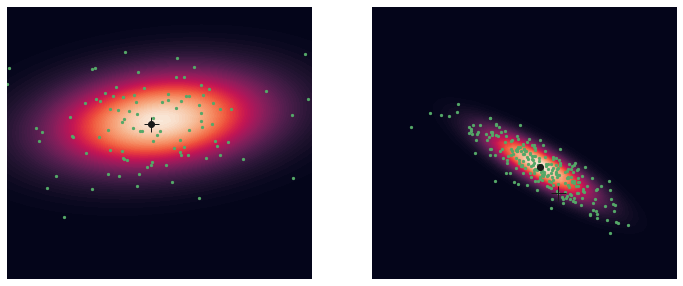

In [5]:
# Create the particle distributions by sampling the parametric Gaussians from before
samples = {
    "Gaussian 1": sia.Particles.init(distributions["Gaussian 1"], 
                                     num_particles=100,
                                     weighted_stats=False),
    "Gaussian 2": sia.Particles.init(distributions["Gaussian 2"], 
                                     num_particles=250,
                                     weighted_stats=True),
}

# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.despine(f, left=True, bottom=True)

# Add the samples to the density plots for the parameteric distributions
i = 0
for name, dist in distributions.items():
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb2d(dist, xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    
    # Add scatter plots for the sample distributions
    sample = samples[name]
    ax[i].scatter(sample.values()[0, :], sample.values()[1, :], s=5, color="g")
    
    # Adds dots for the sample distribution means
    mean = sample.mean()
    ax[i].plot(mean[0], mean[1], ".k", ms=12)
    
    # Adds plusses for the sample distribution modes
    mode = sample.mode()
    ax[i].plot(mode[0], mode[1], "+k", ms=15)
    
    ax[i].set_xlim((-3, 3))
    ax[i].set_ylim((-3, 3))
    ax[i].axis("off")
    
    i+=1

plt.show()

### Kernel density estimators

The `sia.KernelDensity` distribution is a specialization of the particle distribution that builds local kernels around each particle.  This smooths the log probability, improves sampling, and mode finding.  The log probability for the multivariate kernel density is 
$$
\log f(x) = \log \sum_i^N w_i K_H(x-s_i).
$$
The function $K_H$ is a scaled kernel
$$
K_H(x) = \frac{1}{|H|} K(H^{-1} x)
$$
with bandwidth matrix $H > 0$ and kernel function $K(x)$.  Available kernel functions include the uniform, Gaussian, and Epanechnikov kernels.  The bandwidth $H$ affects the smoothing, with higher values increases the smoothing.  By default, the Scott's generalized rule of thumb is used to find the bandwidth.  Bandwidth can also be user specified.

This example shows several kernel densities for samples drawn from the standard normal distribution.

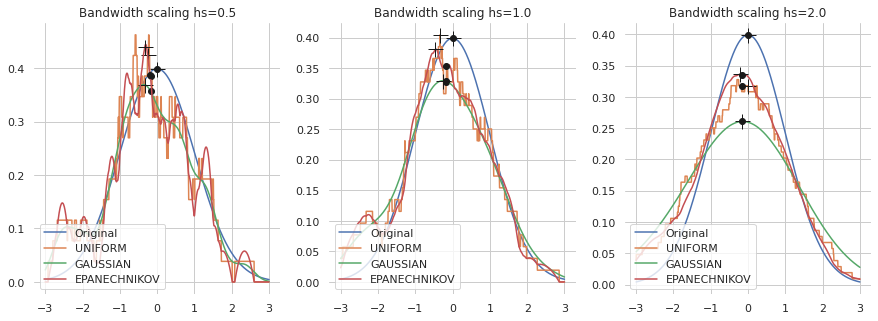

In [6]:
# Test cases
Nsamples = 50
bandwidths = [0.5, 1.0, 2.0]
kernels = [sia.Kernel.UNIFORM, sia.Kernel.GAUSSIAN, sia.Kernel.EPANECHNIKOV]

# Define the standard normal and sample from it
original = sia.Gaussian(mean=0, variance=1)
sample = sia.Particles.init(original, Nsamples)

# Plot the 1D kernel densities
ncols = len(bandwidths)
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 5))
sns.despine(f, left=True, bottom=True)

x = np.linspace(-3, 3, 1001)
for i in range(ncols):
    for j in range(len(kernels) + 1):
        if j == 0:
            dist = original
            name = "Original"
        else:
            # Create a kernel density and set the bandwidth scaling
            dist = sia.KernelDensity(sample, 
                                     type=kernels[j - 1], 
                                     mode=sia.KernelDensity.SCOTT_RULE,
                                     bandwidth_scaling=bandwidths[i])
            name = kernels[j - 1].name
            
        # Helper to evaluate the probability for multiple samples
        prob = np.exp(sia.logProb1d(dist, x))
        ax[i].plot(x, prob, label=name)
    
        # Add dots for the distribution means
        mean = dist.mean()
        ax[i].plot(mean, np.exp(dist.logProb(mean)), ".k", ms=12)
    
        # Add plusses for the distribution modes
        mode = dist.mode()
        ax[i].plot(mode, np.exp(dist.logProb(mode)), "+k", ms=15)
        ax[i].legend(loc="lower left")
        ax[i].set_title("Bandwidth scaling hs={}".format(bandwidths[i]))
        
plt.show()

Support for multidimensional kernel densities is provided, although KDEs are known to suffer from the curse of dimensionality.  As the state dimension increases, they become increasingly less useful.  This example shows kernel densities for samples drawn from a 2D Gaussian, this time using Scott's rule of thumb for the bandwidth.

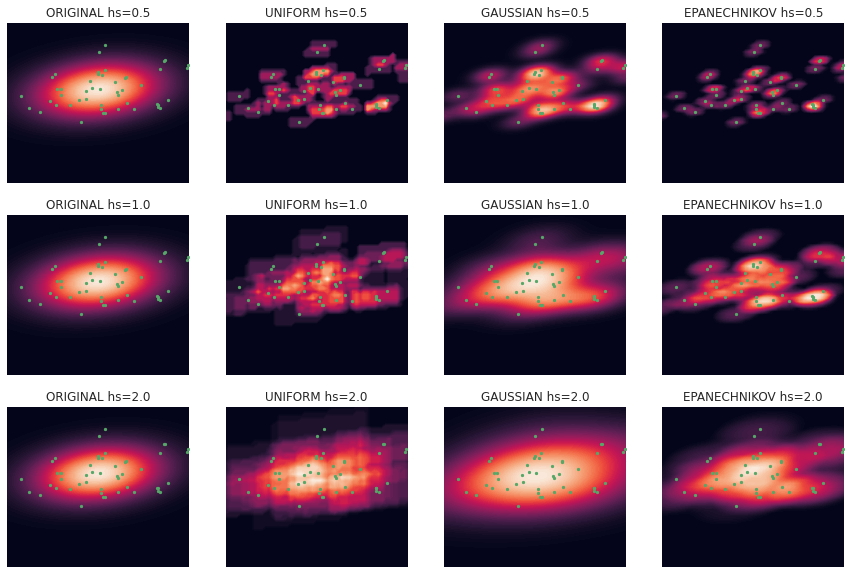

In [7]:
# Define the 2D original density
original = sia.Gaussian(mean=np.array([0, 0.5]),
                        covariance=np.array([[2, 0.2], [0.2, 0.5]]))
sample = sia.Particles.init(original, Nsamples)


# Plot the 2D probability densities
nrows = len(bandwidths)
ncols = len(kernels) + 1
f, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
sns.despine(f, left=True, bottom=True)

for i in range(nrows):
    for j in range(ncols):
        if j == 0:
            dist = original
            name = "ORIGINAL"
        else:
            # Create a kernel density and set the bandwidth scaling
            dist = sia.KernelDensity(sample, 
                                     type=kernels[j - 1], 
                                     mode=sia.KernelDensity.SCOTT_RULE,
                                     bandwidth_scaling=bandwidths[i])
            name = dist.getKernelType().name
            
        # Helper to evaluate the probability for multiple samples
        prob = np.exp(sia.logProb2d(dist, xx.flatten(), yy.flatten()))
        ax[i, j].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    
        # Add scatter plots for the sample distributions
        ax[i, j].scatter(sample.values()[0, :], sample.values()[1, :], s=5, color="g")
        
        ax[i, j].set_xlim((-3, 3))
        ax[i, j].set_ylim((-3, 3))
        ax[i, j].axis("off")
        ax[i, j].set_title("{} hs={}".format(name, bandwidths[i]))
        
plt.show()

### Gaussian mixture models (GMM)

Sia provides a `sia.GMM` implementation for multimodal clustering and classification.  The GMM is a weighted combination of $N$ Gaussian clusters with a log likelihood defined by
$$
\log f(x) = \log \sum_i^N w_i \mathcal{N}(\mu_i,\Sigma_i)
$$

where the sum of priors (weights) $\sum_i w_i = 1$.  Sia provides a method to classify a sample by cluster using `sia.GMM.classify`.   This example shows a mixture model for a 2D GMM with 3 clusters.  The first plot shows the distribution mean and mode, and the second plot shows samples drawn from the model with colors determined by class.

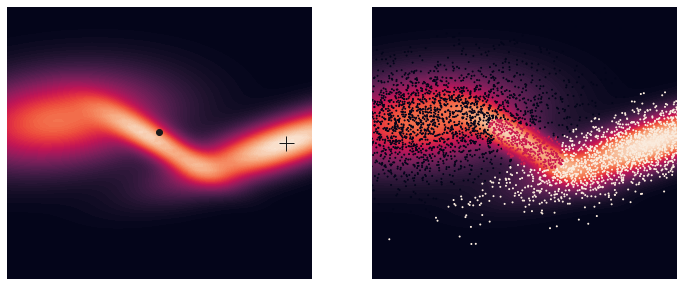

In [8]:
gaussians = [
    sia.Gaussian(mean=np.array([-2.0, 0.5]),
                 covariance=np.array([[2, 0.2], [0.2, 0.5]])),
    sia.Gaussian(mean=np.array([0.0, 0.0]),
                 covariance=np.array([[0.5, -0.3], [-0.3, 0.25]])),
    sia.Gaussian(mean=np.array([2.5, 0.0]),
                 covariance=np.array([[2.0, 0.7], [0.7, 0.4]]))
]
priors = [0.5, 0.1, 0.4]
gmm = sia.GMM(gaussians, priors)

# Draw samples from the distribution and classify
num_samples = 5000
samples = gmm.samples(num_samples)
classes = [gmm.classify(x) for x in samples]
samples = np.array(samples)

# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
x = np.linspace(-3, 3, 51)
y = np.linspace(-3, 3, 51)
xx, yy = np.meshgrid(x, y)
for i in range(2):
    
    # Helper to evaluate the probability for multiple samples
    prob = np.exp(sia.logProb2d(gmm, xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    
    # Show the mean '.' and mode '+' in the first plot
    if i == 0:
        # NOTE: The mode computation is clearly wrong
        mean = gmm.mean()
        ax[i].plot(mean[0], mean[1], ".k", ms=12)
        mode = gmm.mode()
        ax[i].plot(mode[0], mode[1], "+k", ms=15)
        
    # Plot samples and classes by color
    elif i == 1:
        ax[i].scatter(samples[:, 0], samples[:, 1], s=1, c=classes)
    
    ax[i].set_xlim((-3, 3))
    ax[i].set_ylim((-3, 3))
    ax[i].axis("off")
    i+=1

plt.show()

For convenience, `sia.GMM` also provides a constructor for fitting the model to sample data using the Expectation-Maximization (EM) algorithm initialized via kmeans.  If more flexilibility is needed, the `sia.GMM.fit` routine offers options for warm start initialization versus random initialization.  For functionality beyond this, a more advanced and focused Machine Learning library such as `scikit-learn` is recommended.  The following example shows fitting the data above with a new model learning from EM.

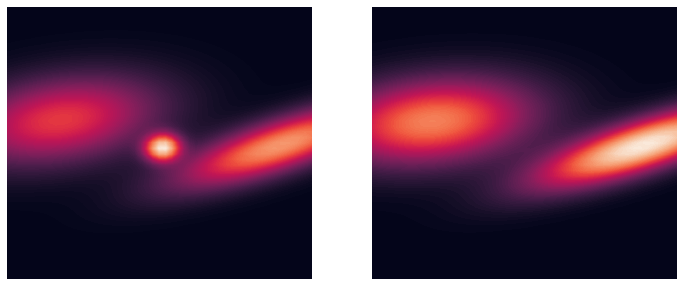

In [9]:
# Add regularization to the covariances to make sure they are positive definite
gmm_fits = [
    sia.GMM(samples.T, K=3, regularization=1e-2),
    sia.GMM(samples.T, K=2, regularization=1e-3),
]

# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

# Evaluate the probability using sia.Distribution.logProb(x)
x = np.linspace(-3, 3, 51)
y = np.linspace(-3, 3, 51)
xx, yy = np.meshgrid(x, y)
for i in range(2):
    # Helper to evaluate the probability for multiple samples
    prob_fit = np.exp(sia.logProb2d(gmm_fits[i], xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob_fit, xx.shape), levels=100)
    ax[i].set_xlim((-3, 3))
    ax[i].set_ylim((-3, 3))
    ax[i].axis("off")
    i+=1

plt.show()

### Gaussian mixture regression (GMR)

`sia.GMR` implements regression that extends GMM to conditional distributions.  It treats some of the state space as an input $x$ and some of it as an output $y$, and therefore only makes sense for distributions with 2 dimensions or more (1 axis for input, 1 for output).  With this separation, GMM is a generative model over the joint probability
$$
p(x, y)
$$
Gaussian mixture regression conditions on this model to predict
$$
p(y|x) = \mathcal{N}(\mu(x), \Sigma(x))
$$
where $\mu(x)$ and $\Sigma(x)$ are determined via Gaussian conditioning on the mixture.  The model is locally linear.  The covariance over the input space and mixture weights determine the contribution of each model, making it similar to a Kernel method.  GMR is particularly useful for learning models of dynamics or sensor measurements.  This example shows the GMM above now with conditioning applied.  On the left case, it is $p(x_2 | x_1)$ and the right case is $p(x_1 | x_2)$.  Note that the multiple intercepts along $y$ are blended in the right case.  This is shown to indicate that applying GMR over arbitrary inputs/outputs to a GMM does not make sense, you need to know the causality of your data to choose this appropriately.

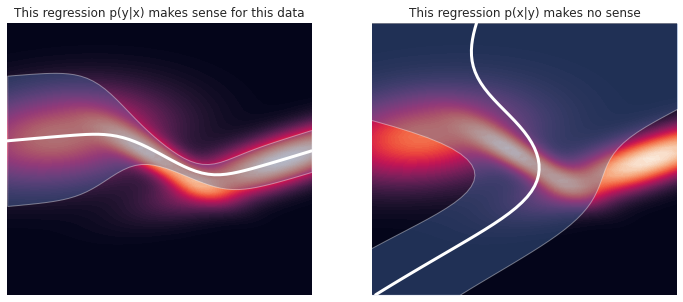

In [10]:
# Plot the probabilities
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

x = np.linspace(-3, 3, 51)
y = np.linspace(-3, 3, 51)

# Case 1: condition on the first variable 'x' to predict the second variable 'y'
gmr1 = sia.GMR(gmm, [0], [1])
gmr1_mu = np.zeros(len(x))
gmr1_sig = np.zeros(len(x))
for i in range(len(x)):
    gaussian = gmr1.predict(np.array([x[i]]))
    gmr1_mu[i] = gaussian.mean()[0]
    gmr1_sig[i] = gaussian.covariance()[0, 0]
ax[0].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
ax[0].fill_between(x, gmr1_mu + 3 * gmr1_sig, gmr1_mu - 3 * gmr1_sig, alpha=0.4)
ax[0].plot(x, gmr1_mu, 'w', lw=3)
ax[0].set_xlim((-3, 3))
ax[0].set_ylim((-3, 3))
ax[0].axis("off")
ax[0].set_title("This regression p(y|x) makes sense for this data")

# Case 2: condition on the second variable 'y' to predict the first variable 'x'
gmr2 = sia.GMR(gmm, [1], [0])
gmr2_mu = np.zeros(len(y))
gmr2_sig = np.zeros(len(y))
for i in range(len(y)):
    gaussian = gmr2.predict(np.array([y[i]]))
    gmr2_mu[i] = gaussian.mean()[0]
    gmr2_sig[i] = gaussian.covariance()[0, 0]
ax[1].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
ax[1].fill_betweenx(y, gmr2_mu + 3 * gmr2_sig, gmr2_mu - 3 * gmr2_sig,  alpha=0.4)
ax[1].plot(gmr2_mu, y, 'w', lw=3)
ax[1].set_xlim((-3, 3))
ax[1].set_ylim((-3, 3))
ax[1].axis("off")
ax[1].set_title("This regression p(x|y) makes no sense")

plt.show()

## Gaussian Process Regression (GPR)

`sia.GPR` implements a multi-dimensional Gaussian Process Regression model that predicts an uncorrelated output vector $y$ given an input vector $x$ for a posterior statistical function $f$
$$
p(y|x) = \mathcal{N}(\mathbb{E}[f(x)], \mathbb{V}[f(x)])
$$
Note that because the output vector is uncorrelated, the output variance $\mathbb{V}[f(x)]$ is a diagonal matrix.  GPR is a  hyperparameteric kernel-based method.  The GP has several hyperparameters $\sigma_f^2$, $\sigma_n^2$, and $l$.  The variance $\sigma_f^2$ controls the uncertainty of the prior distribution, i.e. in regions where there is no training data.  The variance $\sigma_n^2$ determines the uncertainty of the likelihood, i.e. the measurement noise.  The length $l$ is a kernel smoothing term.  Effects of these hyperparameters are shown below.  The top row demonstrates $\sigma_f^2$ (`vf`) where the uncertainty at the boundaries (dominated by the prior) is modified; middle shows $\sigma_n^2$ (`vn`) where the measurement noise is changed, and the bottom shows $l$ (`l`) with more or less blending of the likelihood between training data in $x$.

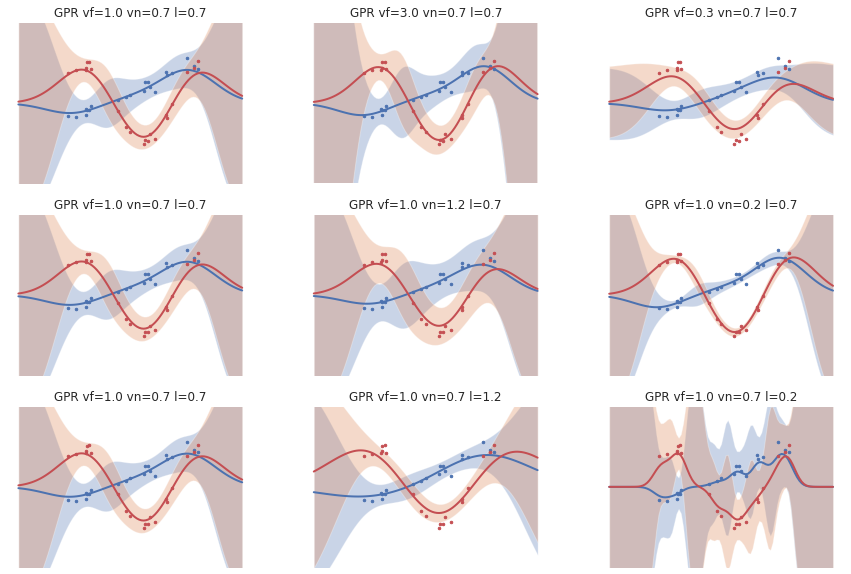

In [11]:
# Generate training data from underlying function
xtrain = np.random.uniform(0, 4, 21)
v = 0.1 * np.random.randn(2, len(xtrain))
ytrain = np.vstack((0.4 * xtrain - 0.5, np.sin(2 * xtrain))) + v

# Plot the raw data
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

# Evaluate several choices of hyper parameters
varf   = [1.0, 3.0, 0.3, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
varn   = [0.7, 0.7, 0.7, 0.7, 1.2, 0.2, 0.7, 0.7, 0.7]
length = [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 1.2, 0.2]

for i in range(len(ax)):
    # Create the GPR object
    gpr = sia.GPR(np.array([xtrain]), ytrain, varn=varn[i], varf=varf[i], length=length[i])

    # Evaluate it
    xtest = np.linspace(-1, 5, 101)
    gpr_mu = np.zeros((2, len(xtest)))
    gpr_sig = np.zeros((2, len(xtest)))
    for k in range(len(xtest)):
        gaussian = gpr.predict(np.array([xtest[k]]))
        gpr_mu[:, k] = gaussian.mean()
        gpr_sig[:, k] = np.diag(gaussian.covariance())
    
    # Plot the belief for each axis and overlay the training data
    ax[i].fill_between(xtest, gpr_mu[0, :] + 3 * gpr_sig[0, :], gpr_mu[0, :] - 3 * gpr_sig[0, :],  alpha=0.3)
    ax[i].plot(xtest, gpr_mu[0, :], 'b', lw=2)
    ax[i].fill_between(xtest, gpr_mu[1, :] + 3 * gpr_sig[1, :], gpr_mu[1, :] - 3 * gpr_sig[1, :],  alpha=0.3)
    ax[i].plot(xtest, gpr_mu[1, :], 'r', lw=2)
    ax[i].plot(xtrain, ytrain[0, :], '.b', ms=5)
    ax[i].plot(xtrain, ytrain[1, :], '.r', ms=5)
    ax[i].set_ylim((-2, 2))
    ax[i].axis("off")
    ax[i].set_title("GPR vf={} vn={} l={}".format(varf[i], varn[i], length[i]));

**Hyperparameter optimization.** Optimization dependencies are not included with `sia`, however GPR provides a loss function `GPR.negLogLikLoss()` of the training data and parameter access via `GPR.getHyperparameters()` that make it easy to plug in to a 3rd party optimzer, such as scipy.  Here we optimize the GPR hyperparameters using the L-BFGS-B algorithm.

[0.1 1.  1. ]
[0.2        1.73491115 1.08063708]


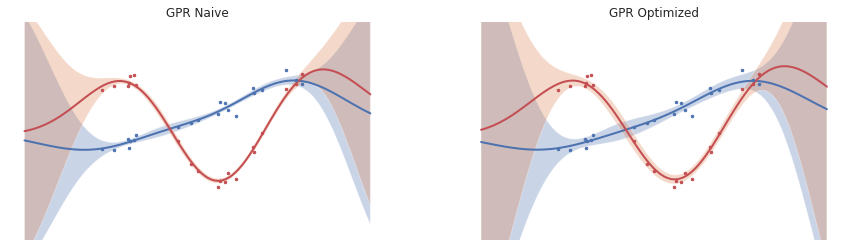

In [12]:
from scipy.optimize import minimize

gpr_naive = sia.GPR(np.array([xtrain]), ytrain)
gpr_optm = sia.GPR(np.array([xtrain]), ytrain)

# Optimize the hyperparameters using the L-BFGS-B algorithm
# and the negative log likelihood loss function provided by the sia.GPR
res = minimize(gpr_optm.negLogLikLoss, 
               x0=gpr_optm.getHyperparameters(),                
               bounds=((2e-1, 10), (1e-2, 50), (1e-2, 50)),
               options={'disp': True},
               method='L-BFGS-B')
gpr_optm.setHyperparameters(res.x)
print(gpr_naive.getHyperparameters())
print(gpr_optm.getHyperparameters())

models = {
    "Naive": gpr_naive,
    "Optimized": gpr_optm
}

# Plot the raw data
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

for i in range(len(models.values())):
    key = list(models.keys())[i]
    
    # Evaluate it
    xtest = np.linspace(-1, 5, 101)
    gpr_mu = np.zeros((2, len(xtest)))
    gpr_sig = np.zeros((2, len(xtest)))
    for k in range(len(xtest)):
        gaussian = models[key].predict(np.array([xtest[k]]))
        gpr_mu[:, k] = gaussian.mean()
        gpr_sig[:, k] = np.diag(gaussian.covariance())
    
    # Plot the belief for each axis and overlay the training data
    ax[i].fill_between(xtest, gpr_mu[0, :] + 3 * gpr_sig[0, :], gpr_mu[0, :] - 3 * gpr_sig[0, :],  alpha=0.3)
    ax[i].plot(xtest, gpr_mu[0, :], 'b', lw=2)
    ax[i].fill_between(xtest, gpr_mu[1, :] + 3 * gpr_sig[1, :], gpr_mu[1, :] - 3 * gpr_sig[1, :],  alpha=0.3)
    ax[i].plot(xtest, gpr_mu[1, :], 'r', lw=2)
    ax[i].plot(xtrain, ytrain[0, :], '.b', ms=5)
    ax[i].plot(xtrain, ytrain[1, :], '.r', ms=5)
    ax[i].set_ylim((-2, 2))
    ax[i].axis("off")
    ax[i].set_title("GPR {}".format(key));

## Gaussian Process Classification (GPC)

`sia.GPC` implements a multi-dimensional Gaussian Process Classification model that predicts a Dirichlet distribution $p(y|x) = \mathcal{D}(x)$ to describe the softmax probability of seeing a class.  The dimension of the output Dirichlet distribution is based on the max class presented in the training data.  GPC has several hyperparameters $\alpha$, $\sigma_n^2$, and $l$.  The baseline concentration $1 > \alpha > 0$ controls the uncertainty of the Dirichlet prior.  The variance $\sigma_n^2$ determines the uncertainty of the likelihood, i.e. the measurement noise.  The length $l$ is a kernel smoothing term.  Effects of these hyperparameters are shown below.  The top row demonstrates $\alpha$ (`a`), middle shows $\sigma_n^2$ (`vn`), and the bottom shows $l$ (`l`).

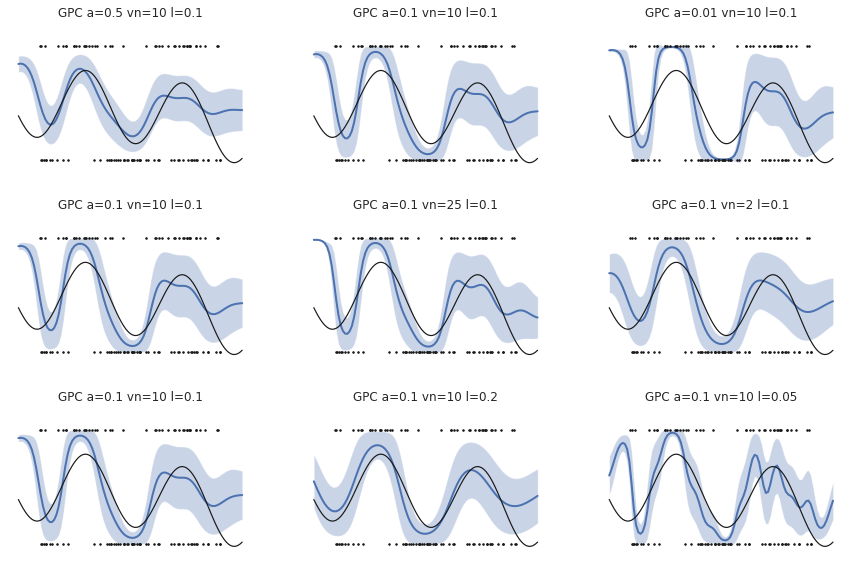

In [13]:
# Generate training data from underlying probability of a binary class
class_prob = lambda x : -0.2 * x ** 2 + 0.6 * np.sin(6 * x) ** 2 + 0.2
# class_prob = lambda x : x >= 0.5

xtrain = np.random.uniform(0, 1, 100)
ptrain = class_prob(xtrain)
ytrain = np.array([int(np.random.uniform(0, 1, 1) <= class_prob(x)) for x in xtrain])

# Plot the raw data
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

# Evaluate several choices of hyper parameters
alpha  = [0.5, 0.1, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
varn   = [10, 10, 10, 10, 25, 2, 10, 10, 10]
length = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.05]

for i in range(len(ax)):
    # Create the GPC object
    gpc = sia.GPC(np.array([xtrain]), ytrain, alpha=alpha[i], varf=varn[i], length=length[i])

    # Evaluate it
    xtest = np.linspace(-0.1, 1.1, 101)
    ptest = class_prob(xtest)
    gpc_mu = np.zeros((2, len(xtest)))
    gpc_sig = np.zeros((2, len(xtest)))
    for k in range(len(xtest)):
        dirichlet = gpc.predict(np.array([xtest[k]]))
        gpc_mu[:, k] = dirichlet.mean()
        gpc_sig[:, k] = np.diag(dirichlet.covariance())
    
    # Plot the belief for each axis and overlay the training data
    ax[i].fill_between(xtest, gpc_mu[1, :] + 2 * gpc_sig[1, :], gpc_mu[1, :] - 2 * gpc_sig[1, :],  alpha=0.3)
    ax[i].plot(xtest, gpc_mu[1, :], 'b', lw=2)
    ax[i].plot(xtrain, ytrain, '.k', ms=3)
    ax[i].plot(xtest, ptest, 'k', lw=1.2)
    ax[i].set_ylim((-0.2, 1.2))
    ax[i].axis("off")
    ax[i].set_title("GPC a={} vn={} l={}".format(alpha[i], varn[i], length[i]));